# **Jesus Ugarte**

**University of Central Florida**

**Pulmonary Desease prediction**

**What is Pneumonia?**

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.

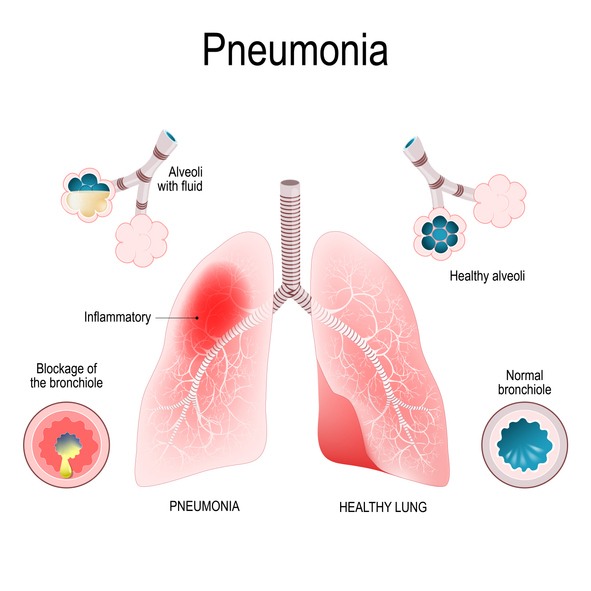

**Importing the Necessary Libraries for the Program to Run**

In [ ]:
import pandas as pd
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import os
import shutil
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential , Model
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, AveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import layers, preprocessing, optimizers
from glob import glob
import cv2


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


The images folder contains the raw image files that you will use to build and train your network (training data), as well as generate your score (test data)

The training_data_metadata.csv file contains information on the training data: an id, the name of the associated image file, the general label of the image (normal or phemonia), the cause (blank, covid, sars, etc), and the type (blank, virus, bacteria, etc).

The test_data_metadata.csv file contains information on the test data: an id and the name of the associated image file

For this competition, you are predicting the type of each image (1 for normal, 2 for virus, 3 for bacteria, 4 for stress-smoking). Your submission will only include the image id and your prediction. The submission.csv file provides an example.

**DATA PREPROCESSING**

**IMPORTING DATA**

In [ ]:
# IMPORTING DATA
train_data = pd.read_csv('/content/drive/MyDrive/Assignment 5 -ML/assignment5_training_data_metadata.csv')
sample_data = pd.read_csv('/content/drive/MyDrive/Assignment 5 -ML/assignment5_submission.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Assignment 5 -ML/assignment5_test_data_metadata.csv')

#TAKING A LOOK AT TRAIN DATA
train_data.sample(10)

,id,image_name,label,cause,type
4698,4698,person616_bacteria_2487.jpeg,Pnemonia,NaN,bacteria
441,441,IM-0590-0001.jpeg,Normal,NaN,NaN
591,591,NORMAL2-IM-0395-0001-0002.jpeg,Normal,NaN,NaN
2985,2985,person24_bacteria_111.jpeg,Pnemonia,NaN,bacteria
908,908,NORMAL2-IM-0865-0001.jpeg,Normal,NaN,NaN
1403,1403,person1146_bacteria_3091.jpeg,Pnemonia,NaN,bacteria
3305,3305,person291_bacteria_1376.jpeg,Pnemonia,NaN,bacteria
1382,1382,person1158_bacteria_3103.jpeg,Pnemonia,NaN,bacteria
2682,2682,person1728_bacteria_4555.jpeg,Pnemonia,NaN,bacteria
237,237,IM-0428-0001.jpeg,Normal,NaN,NaN


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5286 entries, 0 to 5285
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5286 non-null   int64 
 1   image_name  5286 non-null   object
 2   label       5286 non-null   object
 3   cause       69 non-null     object
 4   type        3944 non-null   object
dtypes: int64(1), object(4)
memory usage: 206.6+ KB


In [ ]:
test_data.sample(10)

,id,image_name
354,5663,person124_bacteria_590.jpeg
598,5907,person1662_virus_2875.jpeg
367,5676,person121_bacteria_575.jpeg
188,5497,NORMAL2-IM-0110-0001.jpeg
156,5465,NORMAL2-IM-0229-0001.jpeg
249,5558,person1616_virus_2802.jpeg
69,5378,IM-0050-0001.jpeg
18,5327,NORMAL2-IM-0066-0001.jpeg
385,5694,person113_bacteria_543.jpeg
471,5780,person82_bacteria_405.jpeg


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          624 non-null    int64 
 1   image_name  624 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.9+ KB


Creating the labels for train data before creating of new dataset

In [ ]:
label_data = train_data
columns = ['image_name', 'label', 'type']

label_data = label_data.filter(columns)
label_data

,image_name,label,type
0,IM-0128-0001.jpeg,Normal,NaN
1,IM-0127-0001.jpeg,Normal,NaN
2,IM-0125-0001.jpeg,Normal,NaN
3,IM-0122-0001.jpeg,Normal,NaN
4,IM-0119-0001.jpeg,Normal,NaN
...,...,...,...
5281,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,Pnemonia,Virus
5282,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,Pnemonia,Virus
5283,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,Pnemonia,Virus
5284,1-s2.0-S0140673620303706-fx1_lrg.jpg,Pnemonia,Virus


For now, I will try splitting data labels for trainign first!!

**Dividing labels for train and Test set**

In [ ]:
train_labels, val_labels = train_test_split(label_data.values, test_size=0.1)
print(train_labels.shape)
print(val_labels.shape)

(4757, 3)
(529, 3)


**Preparing train and validation image paths**

In [ ]:
train_f = '/content/drive/MyDrive/Assignment 5 -ML/images/images/train'

train_paths = [os.path.join(train_f, image[0]) for image in train_labels]
val_paths = [os.path.join(train_f, image[0]) for image in val_labels]

print(len(train_paths))
print(len(val_paths))

4757
529


**Preparing test image paths**

Getting info from test Metadata

In [ ]:
test_label_data = test_data
columns = ['image_name', 'id']

test_label_data = test_label_data.filter(columns)
test_label_data

,image_name,id
0,IM-0021-0001.jpeg,5309
1,IM-0019-0001.jpeg,5310
2,IM-0017-0001.jpeg,5311
3,IM-0016-0001.jpeg,5312
4,IM-0015-0001.jpeg,5313
...,...,...
619,person1637_virus_2834.jpeg,5928
620,person1635_virus_2831.jpeg,5929
621,person1634_virus_2830.jpeg,5930
622,person1633_virus_2829.jpeg,5931


In [ ]:
test_f = '/content/drive/MyDrive/Assignment 5 -ML/images/images/test'
test_paths = [os.path.join(test_f, image[0]) for image in test_label_data.values]

print(len(test_paths))

624


Neat, It works!!

**Moving Files to New DATASET FOLDER**

I am creadting the directories If they had not been created and then i am copying the files from the image direcrory to their respective one!

In [ ]:
dir_path1 = '/content/drive/MyDrive/Assignment 5 -ML/Dataset/train/pneumonia'
dir_path2 = '/content/drive/MyDrive/Assignment 5 -ML/Dataset/train/normal'

if not os.path.exists('/content/drive/MyDrive/Assignment 5 -ML/Dataset/train'):

  for i in range(len(train_labels)):
    
    # check if directory exists or not yet
    if not os.path.exists(dir_path1):
        os.makedirs(dir_path1)

    # check if directory exists or not yet
    if not os.path.exists(dir_path2):
        os.makedirs(dir_path2)

    if os.path.exists(train_paths[i]):

      if train_labels[i][1] == 'Pnemonia':
        # move files into created directory
        shutil.copy2(train_paths[i], dir_path1)
        
      elif train_labels[i][1] == 'Normal':
        shutil.copy2(train_paths[i], dir_path2)

In [ ]:
dir_path1 = '/content/drive/MyDrive/Assignment 5 -ML/Dataset/val/pneumonia'
dir_path2 = '/content/drive/MyDrive/Assignment 5 -ML/Dataset/val/normal'

if not os.path.exists('/content/drive/MyDrive/Assignment 5 -ML/Dataset/val'):

  for i in range(len(val_labels)):
    
    # check if directory exists or not yet
    if not os.path.exists(dir_path1):
        os.makedirs(dir_path1)

    # check if directory exists or not yet
    if not os.path.exists(dir_path2):
        os.makedirs(dir_path2)

    if os.path.exists(train_paths[i]):

      if train_labels[i][1] == 'Pnemonia':
        # move files into created directory
        shutil.copy2(train_paths[i], dir_path1)
        
      elif train_labels[i][1] == 'Normal':
        shutil.copy2(train_paths[i], dir_path2)

JPEG is a commonly used method of lossy compression for digital photography (image)." There should be no problem in changing the extensions. In terms of the file itself there is really no consequence to renaming a JPEG as . jpg

In [ ]:
dir_path1 = '/content/drive/MyDrive/Assignment 5 -ML/Dataset/test/all_classes'
replace_path = '/content/drive/MyDrive/Assignment 5 -ML/images/images/test'

test_label_id = test_label_data.iloc[:,1]

if not os.path.exists('/content/drive/MyDrive/Assignment 5 -ML/Dataset/test'):

  for i in range(len(test_label_id)):

    # check if directory exists or not yet
    if not os.path.exists(dir_path1):
        os.makedirs(dir_path1)  
          
    if os.path.exists(test_paths[i]):
      # move files into created directory
      destination = f'{replace_path}/{test_label_id[i]}.jpg'
      shutil.copy2(test_paths[i], destination)
      shutil.copy2(destination, dir_path1)

We know that test metadata is incorrect!! according to the data that I currenlty have!!

**DATA PREPROCESSING IS DONE !!!**

**NEW FILE PATHS**

In [ ]:
train_path = '/content/drive/MyDrive/Assignment 5 -ML/Dataset/train/'
test_path = '/content/drive/MyDrive/Assignment 5 -ML/Dataset/test/'
val_path =  '/content/drive/MyDrive/Assignment 5 -ML/Dataset/val/'

Reading pictures and Train - Test Split

We divide the mixed pictures into NORMAL and PNEUMONIA. We add labels to these. Finally, we define a list of pictures.

In [ ]:
resolution = 256

In [ ]:
def picture_separation(folder):
    y = []
    x = []
    image_list = []
    i = 0
    for foldername in os.listdir(folder):
        if not foldername.startswith('.'):
            for image_filename in os.listdir(folder + "/"+ foldername):
                img_file = cv2.imread(folder + "/" + foldername + '/' + image_filename,0)               
              
                if img_file is not None:
                    img = cv2.resize(img_file,(resolution,resolution))
                    img_arr = img_to_array(img) / 255
                    x.append(img_arr)

                    if foldername == "pneumonia":
                      F_name = f'{image_filename}'
                      if 'virus' in F_name:
                        label = 2
                      elif 'bacteria' in F_name:
                        label = 3
                      else:
                        label = 4
                    elif foldername == "normal":
                      label = 1
                    else:
                      label = 0
                    y.append(label)
                    image_list.append(image_filename)
                                        
    X = np.asarray(x)
    y = np.asarray(y)
    
    return X,y,image_list

**DEFINITION OF X AND Y AXIS**

In [ ]:
X_train, y_train, img_train = picture_separation(train_path)

train_df = pd.DataFrame(img_train, columns=["images"])
train_df["target"] = y_train
train_df

,images,target
0,person508_virus_1021.jpeg,2
1,person520_virus_1039.jpeg,2
2,person534_bacteria_2254.jpeg,3
3,person518_bacteria_2200.jpeg,3
4,person502_bacteria_2119.jpeg,3
...,...,...
4662,IM-0372-0001.jpeg,1
4663,IM-0343-0001.jpeg,1
4664,IM-0347-0001.jpeg,1
4665,IM-0382-0001.jpeg,1


In [ ]:
X_train.shape

(4667, 256, 256, 1)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4667 entries, 0 to 4666
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  4667 non-null   object
 1   target  4667 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 73.0+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


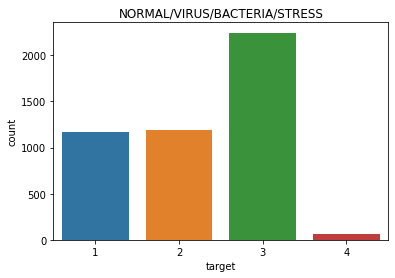

3    2246
2    1190
1    1168
4      63
Name: target, dtype: int64


In [ ]:
sns.countplot(train_df["target"])
plt.title("NORMAL/VIRUS/BACTERIA/STRESS")
plt.show()
print(train_df["target"].value_counts())

In [ ]:
X_val, y_val, img_val = picture_separation(val_path)

val_df = pd.DataFrame(img_train, columns=["images"])
val_df["target"] = y_train
val_df

,images,target
0,person508_virus_1021.jpeg,2
1,person520_virus_1039.jpeg,2
2,person534_bacteria_2254.jpeg,3
3,person518_bacteria_2200.jpeg,3
4,person502_bacteria_2119.jpeg,3
...,...,...
4662,IM-0372-0001.jpeg,1
4663,IM-0343-0001.jpeg,1
4664,IM-0347-0001.jpeg,1
4665,IM-0382-0001.jpeg,1


In [ ]:
X_val.shape

(521, 256, 256, 1)

In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4667 entries, 0 to 4666
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  4667 non-null   object
 1   target  4667 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 73.0+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


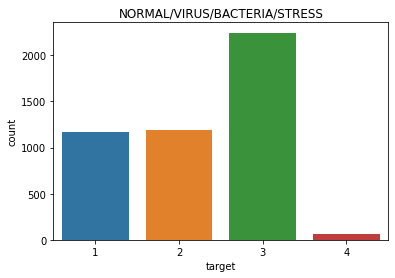

3    2246
2    1190
1    1168
4      63
Name: target, dtype: int64


In [ ]:
sns.countplot(val_df["target"])
plt.title("NORMAL/VIRUS/BACTERIA/STRESS")
plt.show()
print(val_df["target"].value_counts())

In [ ]:
X_test, y_test, img_test = picture_separation(test_path)

test_df = pd.DataFrame(img_test, columns=["images"])
test_df["target"] = y_test
test_df

,images,target
0,5323.jpg,0
1,5324.jpg,0
2,5322.jpg,0
3,5398.jpg,0
4,5396.jpg,0
...,...,...
619,5908.jpg,0
620,5758.jpg,0
621,5739.jpg,0
622,5543.jpg,0


In [ ]:
 full_data = pd.concat([train_df, val_df, test_df], axis=0, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


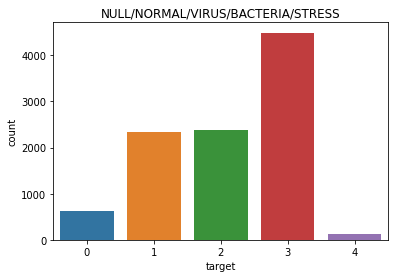

3    4492
2    2380
1    2336
0     624
4     126
Name: target, dtype: int64


In [ ]:
sns.countplot(full_data["target"])
plt.title("NULL/NORMAL/VIRUS/BACTERIA/STRESS")
plt.show()
print(full_data["target"].value_counts())

In this case, class 0 represents values that do not have any classification

Pneumonia, Normal Pictures

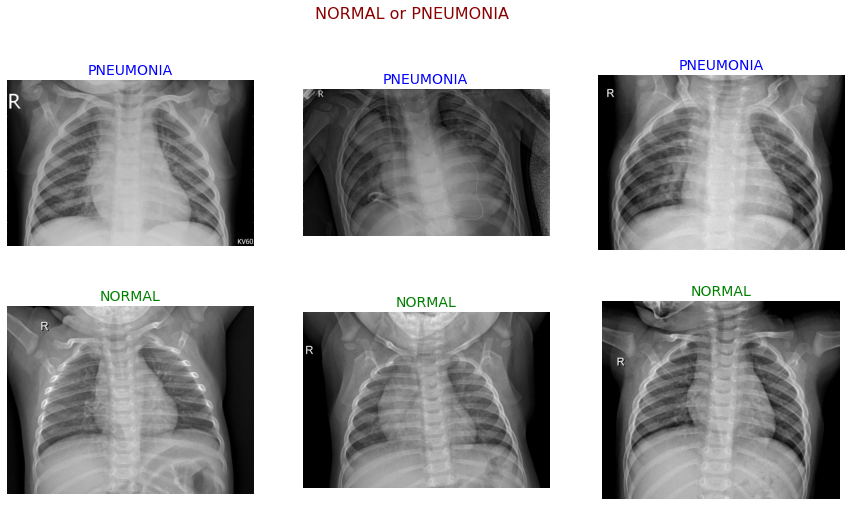

In [ ]:
plt.figure(figsize=(15,8))

plt.subplot(2,3,1) 
img = load_img(train_path + "/pneumonia/" + train_df['images'][1])
plt.imshow(img)
plt.title("PNEUMONIA", color = "blue", size = 14)
plt.axis("off")


plt.subplot(2,3,2) 
img = load_img(train_path + "/pneumonia/" + train_df['images'][2])
plt.imshow(img)
plt.title("PNEUMONIA", color = "blue", size = 14)
plt.axis("off")

plt.subplot(2,3,3) 
img = load_img(train_path + "/pneumonia/" + train_df['images'][3])
plt.imshow(img)
plt.title("PNEUMONIA", color = "blue", size = 14)
plt.axis("off")

plt.subplot(2,3,4) 
img = load_img(train_path + "/normal/" + train_df['images'][4663])
plt.imshow(img)
plt.title("NORMAL", color = "green", size = 14)
plt.axis("off")

plt.subplot(2,3,5) 
img = load_img(train_path + "/normal/" + train_df['images'][4664])
plt.imshow(img)
plt.title("NORMAL", color = "green", size = 14)
plt.axis("off")

plt.subplot(2,3,6) 
img = load_img(train_path + "/normal/" + train_df['images'][4665])
plt.imshow(img)
plt.title("NORMAL", color = "green", size = 14)
plt.axis("off")

plt.suptitle("NORMAL or PNEUMONIA", size = 16, color = "darkred")
plt.show()

In [ ]:
# the shape
X_train.shape

(4667, 256, 256, 1)

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_path,
  image_size=(resolution, resolution),
  batch_size=32,
  color_mode = 'grayscale')

Found 521 files belonging to 2 classes.


I want to use 'grayscale' as the color mode in the parameters!!

In [ ]:
batch_size = 32

**MODEL BUILDING CNN**


In [ ]:
X_train.shape

(4667, 256, 256, 1)

In [ ]:
X_test.shape

(624, 256, 256, 1)

In [ ]:
num_classes = 5

model = tf.keras.Sequential([
                            tf.keras.layers.Flatten(input_shape=(resolution, resolution)),
                            tf.keras.layers.Dense(128, activation='relu'),
                            tf.keras.layers.Dense(num_classes)
                            ])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)               8388736   
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 645       
Total params: 8,389,381
Trainable params: 8,389,381
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

**VISUALIZATION**

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    validation_data=val_ds,
                    callbacks=[early_stopping])

Epoch 1/30
146/146 [==============================] - 4s 27ms/step - loss: 9.6615 - accuracy: 0.5218 - val_loss: 9055.9609 - val_accuracy: 0.0019
Epoch 2/30
146/146 [==============================] - 4s 27ms/step - loss: 1.9421 - accuracy: 0.6200 - val_loss: 8249.0977 - val_accuracy: 0.0134
Epoch 3/30
146/146 [==============================] - 4s 27ms/step - loss: 1.7225 - accuracy: 0.6810 - val_loss: 6157.9058 - val_accuracy: 0.0940
Epoch 4/30
146/146 [==============================] - 4s 27ms/step - loss: 1.4995 - accuracy: 0.6773 - val_loss: 5402.9302 - val_accuracy: 0.0173
Epoch 5/30
146/146 [==============================] - 4s 27ms/step - loss: 1.7320 - accuracy: 0.6794 - val_loss: 5057.9961 - val_accuracy: 0.1708
Epoch 6/30
146/146 [==============================] - 4s 26ms/step - loss: 1.4893 - accuracy: 0.6873 - val_loss: 4669.9941 - val_accuracy: 0.0058
Epoch 7/30
146/146 [==============================] - 4s 26ms/step - loss: 0.8061 - accuracy: 0.7296 - val_loss: 4183.8682 -

In [ ]:
test_loss, test_acc = model.evaluate(X_train,  y_train, verbose=2)

print('\nTest accuracy:', test_acc)

146/146 - 1s - loss: 0.6297 - accuracy: 0.7769

Test accuracy: 0.7769445180892944


**PREDICTION**

Softmax activation will takes a real vector as input and convert it in to a vector of categorical probabilities. ... In summary it convert the result in to a probability distribution

In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

Making sure the prediciton array is looking good

In [ ]:
predictions = probability_model.predict(X_test)
predictions

array([[4.21337640e-16, 2.37727717e-01, 3.91316652e-01, 3.70953947e-01,
        1.66336588e-06],
       [6.17549884e-17, 6.28287271e-02, 2.40080375e-02, 8.01135004e-01,
        1.12028137e-01],
       [1.35243575e-17, 1.81636555e-04, 1.88381865e-03, 9.52506244e-01,
        4.54281792e-02],
       ...,
       [1.32169062e-16, 8.59814114e-04, 1.99108031e-02, 9.79227126e-01,
        2.18641298e-06],
       [1.49406542e-13, 1.10796519e-01, 6.63168907e-01, 2.26034597e-01,
        6.79219125e-09],
       [1.88565331e-12, 1.28602923e-03, 6.61353543e-02, 9.32557046e-01,
        2.16202079e-05]], dtype=float32)

We examine the accuracy and loss value of the model we created.

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**VISUALIZING PREDICTION AGAINST TRAIN**

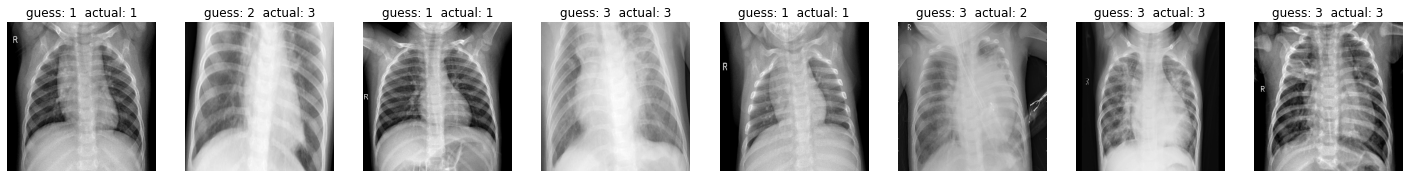

In [ ]:
y_train_results = probability_model.predict([X_train])

c = 8

fig, subplots = plt.subplots(1, c)
fig.set_size_inches(25, 3)
for i in range(c):
    n = np.random.randint(0, len(X_train))
    guess = str(round(np.argmax(y_train_results[n])))

    subplot = subplots[i]
    subplot.imshow(X_train[n].reshape((resolution, resolution)), cmap="gray")
    subplot.set_title(f"guess: {guess}  actual: {y_train[n]}")
    subplot.axis("off")
plt.show()

**VISUALIZING PREDICTION AGAINST VALIDATION DATA**

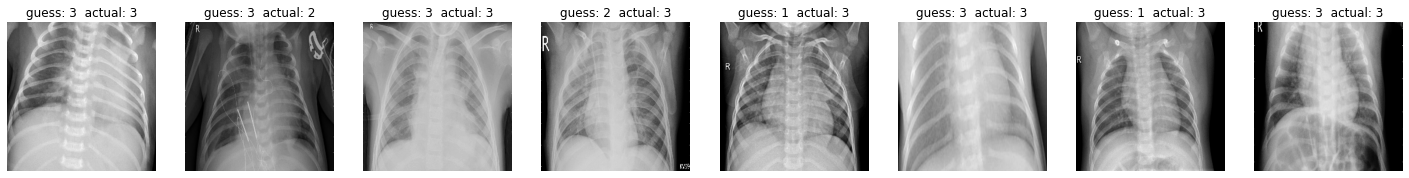

In [ ]:
y_val_results = probability_model.predict([X_val])

c = 8

fig, subplots = plt.subplots(1, c)
fig.set_size_inches(25, 3)
for i in range(c):
    n = np.random.randint(0, len(X_val))
    guess = str(round(np.argmax(y_val_results[n])))

    subplot = subplots[i]
    subplot.imshow(X_val[n].reshape((resolution, resolution)), cmap="gray")
    subplot.set_title(f"guess: {guess}  actual: {y_train[n]}")
    subplot.axis("off")
plt.show()

**VISUALIZING PREDICTION AGAINST TEST DATA**

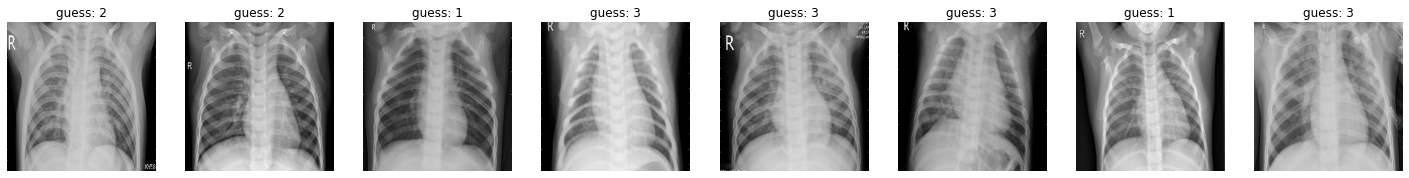

In [ ]:
y_test_results = probability_model.predict([X_test])

c = 8

fig, subplots = plt.subplots(1, c)
fig.set_size_inches(25, 3)
for i in range(c):
    n = np.random.randint(0, len(X_test))
    guess = str(round(np.argmax(y_test_results[n])))

    subplot = subplots[i]
    subplot.imshow(X_test[n].reshape((resolution, resolution)), cmap="gray")
    subplot.set_title(f"guess: {guess}")
    subplot.axis("off")
plt.show()

**VERIFICATION**

In [ ]:
class_names = ['0', '1', '2', '3', '4', '5']

def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img.reshape(resolution, resolution))

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(5))
  plt.yticks([])
  thisplot = plt.bar(range(5), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

**VERIFICATION FOR TRAIN SET**

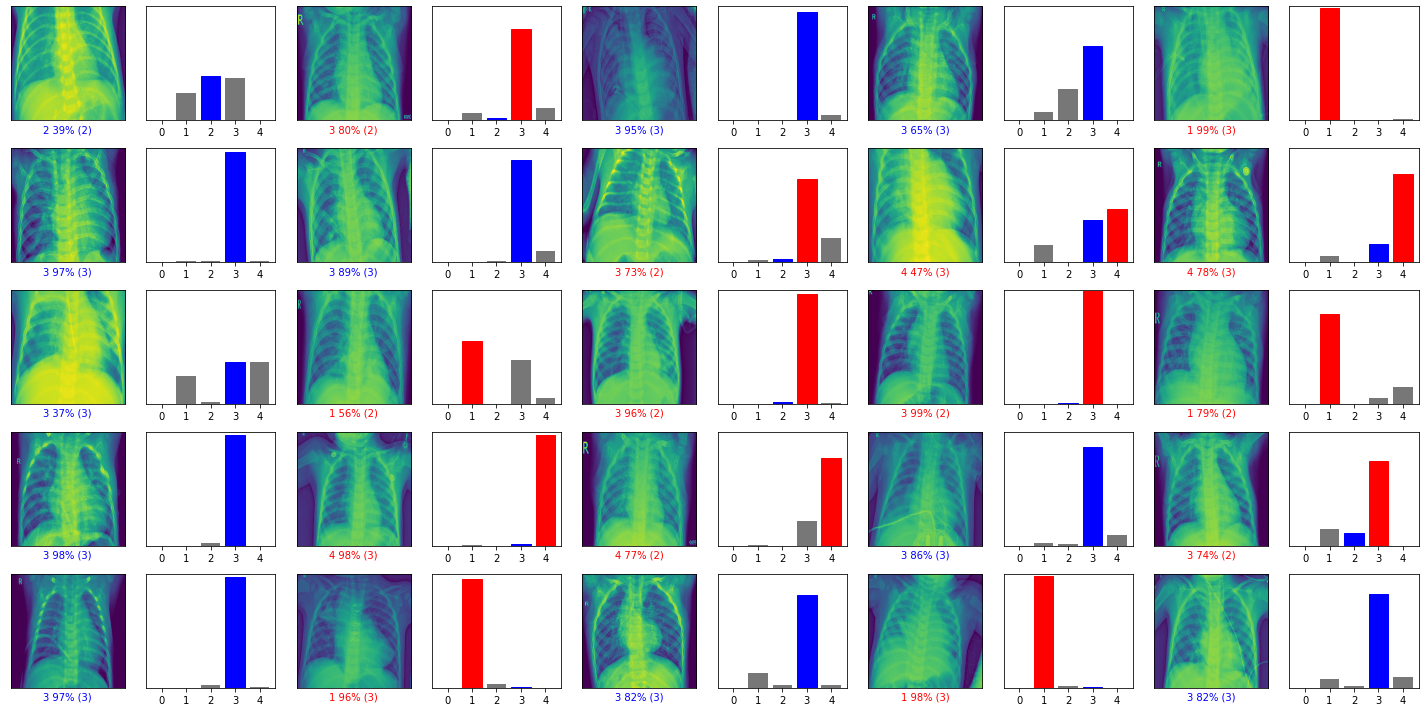

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_train, X_train)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_train)
plt.tight_layout()
plt.show()

**VERIFICATION FOR VALIDATION SET**

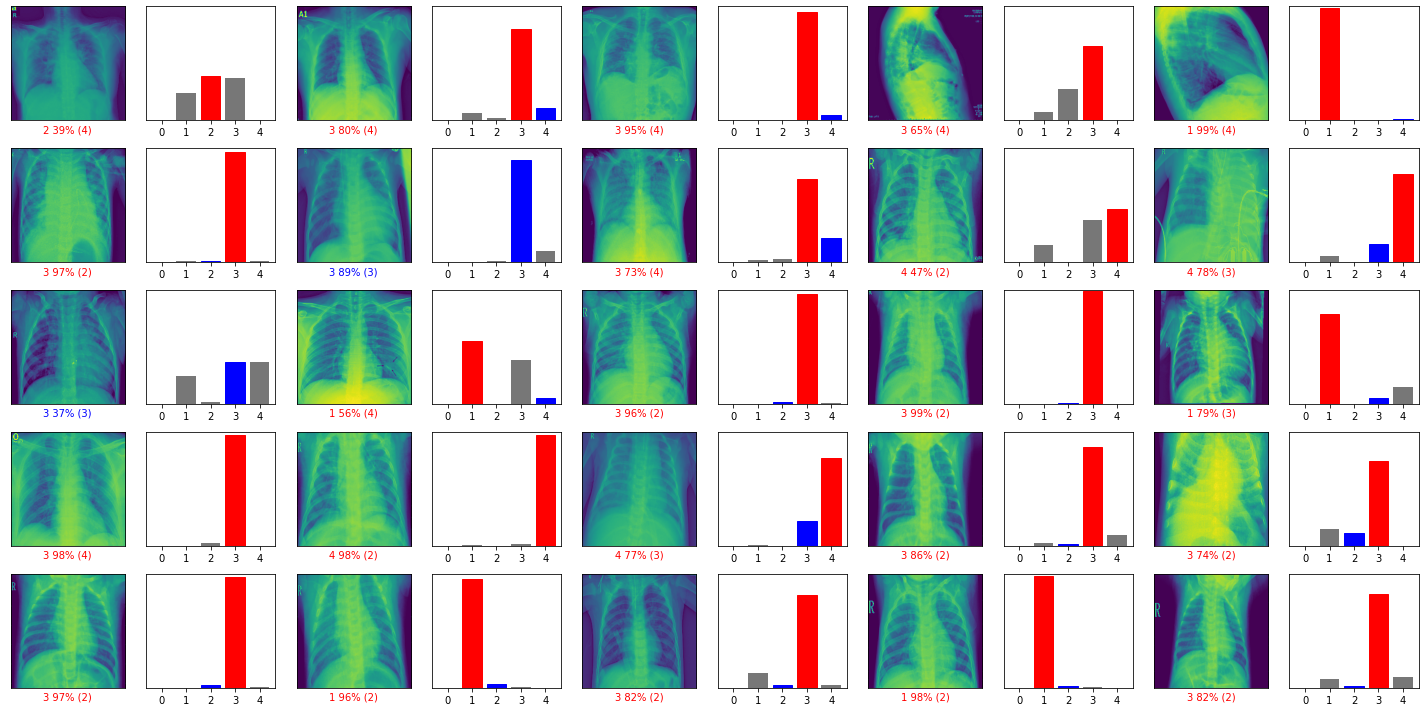

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_val, X_val)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_val)
plt.tight_layout()
plt.show()

**VERIFICATION FOR TEST SET**

test does not have any predicted value, hence all vlaues expect a 0 for default. however. I will print the prediction for them

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

**GENERATING CSV FILE WITH TEST PREDICTIONS**

In [ ]:
X_test.shape

In [ ]:
#Generating CSV File with Prediction
y_pred = probability_model.predict([X_test])
output = pd.DataFrame({'id': test_label_id})
output = output.set_index('id')
output['type'] = np.argmax(y_pred, axis=1)
output.to_csv("submission.csv")
output

I noticed, the model is a little bit inconsistent the highest score I have got in the leaderboard is 0.67 which is good !!

Very Challenging Assignment!! Many Days to learn and complete =)